#**Description de projet**<br>
Vous êtes Data Scientist au sein d'une société financière, nommée "Prêt à dépenser",  qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.

L’entreprise souhaite développer un modèle de scoring de la probabilité de défaut de paiement du client pour étayer la décision d'accorder ou non un prêt à un client potentiel en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de transparence vis-à-vis des décisions d’octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l’entreprise veut incarner.

Elle décide donc de développer un dashboard interactif pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement. <BR>

##**P7_nettoyage.ipynb**<br>
Cette notebook sert à la **sélection de features et au nettyage de données**, en référant le kernel [Kaggle](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering/notebook#Modeling). Le kernel Kaggle est réalisé ici pas à pas pour mieux comprendre les données et adapter les codes à mes besoins(surtout adapter le code aux limites de la puissance de calcul sur Colab).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import functions
import importlib
importlib.reload(functions)
from functions import *
import seaborn as sns
# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')
import gc
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_row', 500)

In [ ]:
# list of files we have
path = 'drive/MyDrive/TechnicalLearning/Python/Jupyter/OC_DS_Projets/P7/file'
os.listdir(path)

['test_bureau_raw.csv',
 'train_bureau_raw.csv',
 'test_previous_raw.csv',
 'HomeCredit_columns_description.csv',
 'credit_card_balance.csv',
 'bureau_balance.csv',
 'POS_CASH_balance.csv',
 'application_test.csv',
 'bureau.csv',
 'installments_payments.csv',
 'sample_submission.csv',
 'previous_application.csv',
 'application_train.csv',
 'train_previous_raw.csv']

In [ ]:
# import data
# actual application loans (test: without TARGET, train: with TARGET)
app_test = pd.read_csv(os.path.join(path, 'application_test.csv'))
app_train = pd.read_csv(os.path.join(path, 'application_train.csv'))
# bur: previous credit records in other financial institution
# bur_balance: monthly balance of credit records in 'bur'
bur = pd.read_csv(os.path.join(path, 'bureau.csv'))
bur_balance = pd.read_csv(os.path.join(path, 'bureau_balance.csv'))
# monthly balance of credit card in this bank(Home Credit)
credit_balance = pd.read_csv(os.path.join(path, 'credit_card_balance.csv'))
# repayment history for previous credit in Home Credit
ins_pay = pd.read_csv(os.path.join(path, 'installments_payments.csv'))
# previous credit application in Home Credit
pre_app = pd.read_csv(os.path.join(path, 'previous_application.csv'))
# monthly data about previous point of sale or cash loans in Home Credit.
cash = pd.read_csv(os.path.join(path, 'POS_CASH_balance.csv'))
# sample of submission
sample_sub = pd.read_csv(os.path.join(path, 'sample_submission.csv'))
# description of features
columns_description = pd.read_csv(
    os.path.join(path, 'HomeCredit_columns_description.csv'),
    encoding= 'unicode_escape')

#I. Merge manually
In this part, we merge the 'Bureau' features manually step by step for better understanding. In the next part, we will replace all these manual merging by functions.

## Merge manually features 'bureau'
Merge features in 'bureau', including numeric features and categorical features<br>

In [ ]:
# read bureau info
bur.head(2)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN


### Numeric features

#### Previous loan counts
'count' of all credit records

In [ ]:
# Group the client ID, count the number of previous loans for each client ID
previous_loan_counts = bur.groupby('SK_ID_CURR', as_index=False)\
['SK_ID_BUREAU'].count().rename(columns={
    'SK_ID_BUREAU': 'previous_loan_counts'})
previous_loan_counts.head(2)

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8


In [ ]:
# join to training data on client ID
train = app_train.merge(previous_loan_counts, how='left', on='SK_ID_CURR')
train['previous_loan_counts'] = train['previous_loan_counts'].fillna(0)
train.head(2)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,previous_loan_counts
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,8.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


#### Aggregation statistics
feature engineering: make 'count', 'mean', 'max', 'min', 'sum' of all features

In [ ]:
# Group by the client id, calculate aggregation statistics
bur_agg = bur.drop(columns = ['SK_ID_BUREAU'])\
.groupby('SK_ID_CURR', as_index = False).agg(
    ['count', 'mean', 'max', 'min', 'sum']).reset_index()
bur_agg.head(2)

SK_ID_CURR DAYS_CREDIT              ...  AMT_ANNUITY                       
                   count   mean  max  ...         mean      max  min      sum
0     100001           7 -735.0  -49  ...  3545.357143  10822.5  0.0  24817.5
1     100002           8 -874.0 -103  ...     0.000000      0.0  0.0      0.0

[2 rows x 61 columns]

In [ ]:
# flatten bur_agg dataframe
# List of column names
columns = ['SK_ID_CURR']

# Iterate through the variables names
for var in bur_agg.columns.levels[0]:
    # Skip the id name
    if var != 'SK_ID_CURR':
        
        # Iterate through the stat names
        for stat in bur_agg.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('bureau_%s_%s' % (var, stat))

bur_agg.columns = columns
bur_agg.head(2)

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_count,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_DAYS_ENDDATE_FACT_count,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_ENDDATE_FACT_min,bureau_DAYS_ENDDATE_FACT_sum,bureau_AMT_CREDIT_MAX_OVERDUE_count,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_max,bureau_AMT_CREDIT_MAX_OVERDUE_min,bureau_AMT_CREDIT_MAX_OVERDUE_sum,bureau_CNT_CREDIT_PROLONG_count,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_min,bureau_CNT_CREDIT_PROLONG_sum,bureau_AMT_CREDIT_SUM_count,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_LIMIT_count,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_AMT_CREDIT_SUM_LIMIT_min,bureau_AMT_CREDIT_SUM_LIMIT_sum,bureau_AMT_CREDIT_SUM_OVERDUE_count,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.0,-49,-1572,-5145,7,0.0,0,0,0,7,82.428571,1778.0,-1329.0,577.0,4,-825.5,-544.0,-1328.0,-3302.0,0,NaN,NaN,NaN,0.000,7,0.0,0,0,0,7,207623.571429,378000.0,85500.0,1453365.000,7,85240.928571,373239.0,0.0,596686.5,6,0.00000,0.000,0.0,0.000,7,0.0,0.0,0.0,0.0,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.0,-103,-1437,-6992,8,0.0,0,0,0,6,-349.000000,780.0,-1072.0,-2094.0,6,-697.5,-36.0,-1185.0,-4185.0,5,1681.029,5043.645,0.0,8405.145,8,0.0,0,0,0,8,108131.945625,450000.0,0.0,865055.565,5,49156.200000,245781.0,0.0,245781.0,4,7997.14125,31988.565,0.0,31988.565,8,0.0,0.0,0.0,0.0,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0


In [ ]:
# merge with training data
train = train.merge(bur_agg, on = 'SK_ID_CURR', how = 'left')
train.head(2)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,bureau_AMT_CREDIT_MAX_OVERDUE_count,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_max,bureau_AMT_CREDIT_MAX_OVERDUE_min,bureau_AMT_CREDIT_MAX_OVERDUE_sum,bureau_CNT_CREDIT_PROLONG_count,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_min,bureau_CNT_CREDIT_PROLONG_sum,bureau_AMT_CREDIT_SUM_count,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_LIMIT_count,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_AMT_CREDIT_SUM_LIMIT_min,bureau_AMT_CREDIT_SUM_LIMIT_sum,bureau_AMT_CREDIT_SUM_OVERDUE_count,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,5.0,1681.029,5043.645,0.0,8405.145,8.0,0.0,0.0,0.0,0.0,8.0,108131.945625,450000.0,0.0,865055.565,5.0,49156.2,245781.0,0.0,245781.0,4.0,7997.14125,31988.565,0.0,31988.565,8.0,0.0,0.0,0.0,0.0,8.0,-499.875,-7.0,-1185.0,-3999.0,7.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,4.0,0.000,0.000,0.0,0.000,4.0,0.0,0.0,0.0,0.0,4.0,254350.125000,810000.0,22248.0,1017400.500,4.0,0.0,0.0,0.0,0.0,4.0,202500.00000,810000.000,0.0,810000.000,4.0,0.0,0.0,0.0,0.0,4.0,-816.000,-43.0,-2131.0,-3264.0,0.0,NaN,NaN,NaN,0.0


#### Correlation with Target
We can calculate the correlation of all new values with the target. We can use these as an approximation of the variables which may be important for modeling.

In [ ]:
# List of new correlations
new_corrs = []

# Iterate through the columns 
for col in columns:
    # Calculate correlation with the target
    corr = train['TARGET'].corr(train[col])
    
    # Append the list as a tuple

    new_corrs.append((col, corr))

# Sort the correlations by the absolute value
# Make sure to reverse to put the largest values at the front of list
new_corrs = sorted(new_corrs, key = lambda x: abs(x[1]), reverse = True)
new_corrs[:5]

[('bureau_DAYS_CREDIT_mean', 0.08972896721998114),
 ('bureau_DAYS_CREDIT_min', 0.0752482510301036),
 ('bureau_DAYS_CREDIT_UPDATE_mean', 0.06892735266968673),
 ('bureau_DAYS_ENDDATE_FACT_min', 0.05588737984392077),
 ('bureau_DAYS_CREDIT_ENDDATE_sum', 0.0537348956010205)]

None of the new features has a significant correlation with target. Let's check the highest correlated variable in terms of absolute magnitude correlation.

The correlation between bureau_DAYS_CREDIT_mean and the TARGET is 0.0897
Median value for loan that was not repaid = -835.3333
Median value for loan that was repaid =     -1067.0000


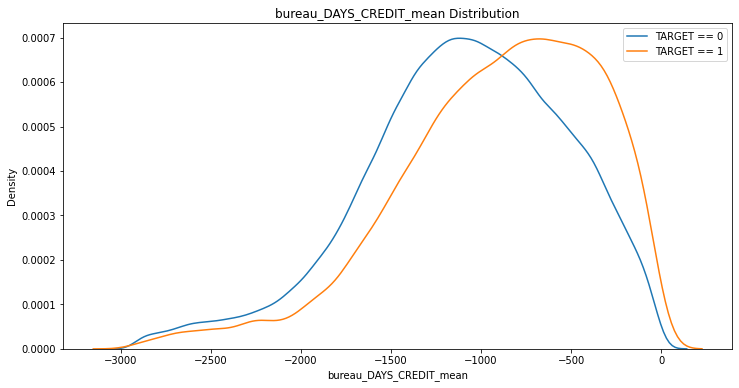

In [ ]:
fc.kde_target(train, 'bureau_DAYS_CREDIT_mean')

#### Agg_numeric function

Encapsulate all previous work into one function: **fc.agg_numeric()**, which could be applied for latter statistical aggregation of numeric columns for any other dataframe. 

In [ ]:
bur_agg_new = fc.agg_numeric(bur, 'SK_ID_CURR', 'bureau' )
bur_agg_new.head(2)

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_count,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_DAYS_ENDDATE_FACT_count,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_ENDDATE_FACT_min,bureau_DAYS_ENDDATE_FACT_sum,bureau_AMT_CREDIT_MAX_OVERDUE_count,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_max,bureau_AMT_CREDIT_MAX_OVERDUE_min,bureau_AMT_CREDIT_MAX_OVERDUE_sum,bureau_CNT_CREDIT_PROLONG_count,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_min,bureau_CNT_CREDIT_PROLONG_sum,bureau_AMT_CREDIT_SUM_count,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_LIMIT_count,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_AMT_CREDIT_SUM_LIMIT_min,bureau_AMT_CREDIT_SUM_LIMIT_sum,bureau_AMT_CREDIT_SUM_OVERDUE_count,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.0,-49,-1572,-5145,7,0.0,0,0,0,7,82.428571,1778.0,-1329.0,577.0,4,-825.5,-544.0,-1328.0,-3302.0,0,NaN,NaN,NaN,0.000,7,0.0,0,0,0,7,207623.571429,378000.0,85500.0,1453365.000,7,85240.928571,373239.0,0.0,596686.5,6,0.00000,0.000,0.0,0.000,7,0.0,0.0,0.0,0.0,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.0,-103,-1437,-6992,8,0.0,0,0,0,6,-349.000000,780.0,-1072.0,-2094.0,6,-697.5,-36.0,-1185.0,-4185.0,5,1681.029,5043.645,0.0,8405.145,8,0.0,0,0,0,8,108131.945625,450000.0,0.0,865055.565,5,49156.200000,245781.0,0.0,245781.0,4,7997.14125,31988.565,0.0,31988.565,8,0.0,0.0,0.0,0.0,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0


### Categorical features

####Aggregation statictics
one-hot encode category features, then calculate count and normalized count of every categories under each category variable.

In [ ]:
# one-hot encode
categorical = pd.get_dummies(bur.select_dtypes('object'))
categorical['SK_ID_CURR'] = bur['SK_ID_CURR']
categorical.head(2)

,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Cash loan (non-earmarked),CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,SK_ID_CURR
0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,215354
1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,215354


In [ ]:
# same as process for numeric feature: groupby ID, calculate aggregation statistics 
# 'sum' represent the count of that category, 'mean' represent the ratio of that category 
categorical_grouped = categorical.groupby('SK_ID_CURR').agg(['sum', 'mean'])
categorical_grouped.head(2)

CREDIT_ACTIVE_Active            ... CREDIT_TYPE_Unknown type of loan     
                            sum      mean  ...                              sum mean
SK_ID_CURR                                 ...                                      
100001                        3  0.428571  ...                                0  0.0
100002                        2  0.250000  ...                                0  0.0

[2 rows x 46 columns]

In [ ]:
# flatten categorica_grouped dataframe columns
group_var = 'SK_ID_CURR'

# Need to create new column names
columns = []

# Iterate through the variables names
for var in categorical_grouped.columns.levels[0]:
    # Skip the grouping variable
    if var != group_var:
        # Iterate through the stat names
        for stat in ['count', 'count_norm']:
            # Make a new column name for the variable and stat
            columns.append('%s_%s' % (var, stat))

#  Rename the columns
categorical_grouped.columns = columns

categorical_grouped.head(2)

,CREDIT_ACTIVE_Active_count,CREDIT_ACTIVE_Active_count_norm,CREDIT_ACTIVE_Bad debt_count,CREDIT_ACTIVE_Bad debt_count_norm,CREDIT_ACTIVE_Closed_count,CREDIT_ACTIVE_Closed_count_norm,CREDIT_ACTIVE_Sold_count,CREDIT_ACTIVE_Sold_count_norm,CREDIT_CURRENCY_currency 1_count,CREDIT_CURRENCY_currency 1_count_norm,CREDIT_CURRENCY_currency 2_count,CREDIT_CURRENCY_currency 2_count_norm,CREDIT_CURRENCY_currency 3_count,CREDIT_CURRENCY_currency 3_count_norm,CREDIT_CURRENCY_currency 4_count,CREDIT_CURRENCY_currency 4_count_norm,CREDIT_TYPE_Another type of loan_count,CREDIT_TYPE_Another type of loan_count_norm,CREDIT_TYPE_Car loan_count,CREDIT_TYPE_Car loan_count_norm,CREDIT_TYPE_Cash loan (non-earmarked)_count,CREDIT_TYPE_Cash loan (non-earmarked)_count_norm,CREDIT_TYPE_Consumer credit_count,CREDIT_TYPE_Consumer credit_count_norm,CREDIT_TYPE_Credit card_count,CREDIT_TYPE_Credit card_count_norm,CREDIT_TYPE_Interbank credit_count,CREDIT_TYPE_Interbank credit_count_norm,CREDIT_TYPE_Loan for business development_count,CREDIT_TYPE_Loan for business development_count_norm,CREDIT_TYPE_Loan for purchase of shares (margin lending)_count,CREDIT_TYPE_Loan for purchase of shares (margin lending)_count_norm,CREDIT_TYPE_Loan for the purchase of equipment_count,CREDIT_TYPE_Loan for the purchase of equipment_count_norm,CREDIT_TYPE_Loan for working capital replenishment_count,CREDIT_TYPE_Loan for working capital replenishment_count_norm,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,7,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,4,0.5,4,0.5,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [ ]:
# merge with training data
train = train.merge(categorical_grouped, left_on = 'SK_ID_CURR', right_index = True, how = 'left')
train.head(2)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,CREDIT_ACTIVE_Sold_count,CREDIT_ACTIVE_Sold_count_norm,CREDIT_CURRENCY_currency 1_count,CREDIT_CURRENCY_currency 1_count_norm,CREDIT_CURRENCY_currency 2_count,CREDIT_CURRENCY_currency 2_count_norm,CREDIT_CURRENCY_currency 3_count,CREDIT_CURRENCY_currency 3_count_norm,CREDIT_CURRENCY_currency 4_count,CREDIT_CURRENCY_currency 4_count_norm,CREDIT_TYPE_Another type of loan_count,CREDIT_TYPE_Another type of loan_count_norm,CREDIT_TYPE_Car loan_count,CREDIT_TYPE_Car loan_count_norm,CREDIT_TYPE_Cash loan (non-earmarked)_count,CREDIT_TYPE_Cash loan (non-earmarked)_count_norm,CREDIT_TYPE_Consumer credit_count,CREDIT_TYPE_Consumer credit_count_norm,CREDIT_TYPE_Credit card_count,CREDIT_TYPE_Credit card_count_norm,CREDIT_TYPE_Interbank credit_count,CREDIT_TYPE_Interbank credit_count_norm,CREDIT_TYPE_Loan for business development_count,CREDIT_TYPE_Loan for business development_count_norm,CREDIT_TYPE_Loan for purchase of shares (margin lending)_count,CREDIT_TYPE_Loan for purchase of shares (margin lending)_count_norm,CREDIT_TYPE_Loan for the purchase of equipment_count,CREDIT_TYPE_Loan for the purchase of equipment_count_norm,CREDIT_TYPE_Loan for working capital replenishment_count,CREDIT_TYPE_Loan for working capital replenishment_count_norm,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0,0.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.5,4.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.5,2.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train.shape

(307511, 229)

#### count_categorical function
encapsulate all previous work into **fc.count_categorical()** function. Use this function for latter process of categorical feature of other table.

In [ ]:
categorical_grouped_new = fc.count_categorical(bur, 'SK_ID_CURR', 'bureau')
categorical_grouped_new.head(2)

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,bureau_CREDIT_CURRENCY_currency 2_count,bureau_CREDIT_CURRENCY_currency 2_count_norm,bureau_CREDIT_CURRENCY_currency 3_count,bureau_CREDIT_CURRENCY_currency 3_count_norm,bureau_CREDIT_CURRENCY_currency 4_count,bureau_CREDIT_CURRENCY_currency 4_count_norm,bureau_CREDIT_TYPE_Another type of loan_count,bureau_CREDIT_TYPE_Another type of loan_count_norm,bureau_CREDIT_TYPE_Car loan_count,bureau_CREDIT_TYPE_Car loan_count_norm,bureau_CREDIT_TYPE_Cash loan (non-earmarked)_count,bureau_CREDIT_TYPE_Cash loan (non-earmarked)_count_norm,bureau_CREDIT_TYPE_Consumer credit_count,bureau_CREDIT_TYPE_Consumer credit_count_norm,bureau_CREDIT_TYPE_Credit card_count,bureau_CREDIT_TYPE_Credit card_count_norm,bureau_CREDIT_TYPE_Interbank credit_count,bureau_CREDIT_TYPE_Interbank credit_count_norm,bureau_CREDIT_TYPE_Loan for business development_count,bureau_CREDIT_TYPE_Loan for business development_count_norm,bureau_CREDIT_TYPE_Loan for purchase of shares (margin lending)_count,bureau_CREDIT_TYPE_Loan for purchase of shares (margin lending)_count_norm,bureau_CREDIT_TYPE_Loan for the purchase of equipment_count,bureau_CREDIT_TYPE_Loan for the purchase of equipment_count_norm,bureau_CREDIT_TYPE_Loan for working capital replenishment_count,bureau_CREDIT_TYPE_Loan for working capital replenishment_count_norm,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,7,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,4,0.5,4,0.5,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


##Merge manually features 'bureau balance'
Different from tables above, this is indexed by bureau ID. So we have to group by 'SK_ID_BUREAU' first, then group by client ID.

In [ ]:
bur_balance.head(2)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C


###Categorical features

In [ ]:
# Calculate aggregation statistics for categorical features of bur_balance
bur_balance_counts = fc.count_categorical(bur_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bur_balance_counts.head(2)

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446


###Numeric features

In [ ]:
# Calculate numeric features statistics for bur_balance dataframe 
bur_balance_agg = fc.agg_numeric(bur_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bur_balance_agg.head(2)

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403


### Combination
Combination of Numeric and categorical features 

In [ ]:
# Dataframe grouped by the loan(SK_ID_BUREAU)
bur_by_loan = bur_balance_agg.merge(bur_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# Merge to include the client ID (SK_ID_CURR)
bur_by_loan = bur_by_loan.merge(bur[['SK_ID_BUREAU', 'SK_ID_CURR']], on = 'SK_ID_BUREAU', how = 'left')

bur_by_loan.head(2)

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm,SK_ID_CURR
0,5001709,97,-48.0,0,-96,-4656,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402,NaN
1,5001710,83,-41.0,0,-82,-3403,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446,162368.0


In [ ]:
# group by client, calculate aggregation statistics
bur_balance_by_client = fc.agg_numeric(bur_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')
bur_balance_by_client.head(2)

,SK_ID_CURR,client_bureau_balance_MONTHS_BALANCE_count_count,client_bureau_balance_MONTHS_BALANCE_count_mean,client_bureau_balance_MONTHS_BALANCE_count_max,client_bureau_balance_MONTHS_BALANCE_count_min,client_bureau_balance_MONTHS_BALANCE_count_sum,client_bureau_balance_MONTHS_BALANCE_mean_count,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_mean_max,client_bureau_balance_MONTHS_BALANCE_mean_min,client_bureau_balance_MONTHS_BALANCE_mean_sum,client_bureau_balance_MONTHS_BALANCE_max_count,client_bureau_balance_MONTHS_BALANCE_max_mean,client_bureau_balance_MONTHS_BALANCE_max_max,client_bureau_balance_MONTHS_BALANCE_max_min,client_bureau_balance_MONTHS_BALANCE_max_sum,client_bureau_balance_MONTHS_BALANCE_min_count,client_bureau_balance_MONTHS_BALANCE_min_mean,client_bureau_balance_MONTHS_BALANCE_min_max,client_bureau_balance_MONTHS_BALANCE_min_min,client_bureau_balance_MONTHS_BALANCE_min_sum,client_bureau_balance_MONTHS_BALANCE_sum_count,client_bureau_balance_MONTHS_BALANCE_sum_mean,client_bureau_balance_MONTHS_BALANCE_sum_max,client_bureau_balance_MONTHS_BALANCE_sum_min,client_bureau_balance_MONTHS_BALANCE_sum_sum,client_bureau_balance_STATUS_0_count_count,client_bureau_balance_STATUS_0_count_mean,client_bureau_balance_STATUS_0_count_max,client_bureau_balance_STATUS_0_count_min,client_bureau_balance_STATUS_0_count_sum,client_bureau_balance_STATUS_0_count_norm_count,client_bureau_balance_STATUS_0_count_norm_mean,client_bureau_balance_STATUS_0_count_norm_max,client_bureau_balance_STATUS_0_count_norm_min,client_bureau_balance_STATUS_0_count_norm_sum,client_bureau_balance_STATUS_1_count_count,client_bureau_balance_STATUS_1_count_mean,client_bureau_balance_STATUS_1_count_max,client_bureau_balance_STATUS_1_count_min,...,client_bureau_balance_STATUS_4_count_count,client_bureau_balance_STATUS_4_count_mean,client_bureau_balance_STATUS_4_count_max,client_bureau_balance_STATUS_4_count_min,client_bureau_balance_STATUS_4_count_sum,client_bureau_balance_STATUS_4_count_norm_count,client_bureau_balance_STATUS_4_count_norm_mean,client_bureau_balance_STATUS_4_count_norm_max,client_bureau_balance_STATUS_4_count_norm_min,client_bureau_balance_STATUS_4_count_norm_sum,client_bureau_balance_STATUS_5_count_count,client_bureau_balance_STATUS_5_count_mean,client_bureau_balance_STATUS_5_count_max,client_bureau_balance_STATUS_5_count_min,client_bureau_balance_STATUS_5_count_sum,client_bureau_balance_STATUS_5_count_norm_count,client_bureau_balance_STATUS_5_count_norm_mean,client_bureau_balance_STATUS_5_count_norm_max,client_bureau_balance_STATUS_5_count_norm_min,client_bureau_balance_STATUS_5_count_norm_sum,client_bureau_balance_STATUS_C_count_count,client_bureau_balance_STATUS_C_count_mean,client_bureau_balance_STATUS_C_count_max,client_bureau_balance_STATUS_C_count_min,client_bureau_balance_STATUS_C_count_sum,client_bureau_balance_STATUS_C_count_norm_count,client_bureau_balance_STATUS_C_count_norm_mean,client_bureau_balance_STATUS_C_count_norm_max,client_bureau_balance_STATUS_C_count_norm_min,client_bureau_balance_STATUS_C_count_norm_sum,client_bureau_balance_STATUS_X_count_count,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_sum,client_bureau_balance_STATUS_X_count_norm_count,client_bureau_balance_STATUS_X_count_norm_mean,client_bureau_balance_STATUS_X_count_norm_max,client_bureau_balance_STATUS_X_count_norm_min,client_bureau_balance_STATUS_X_count_norm_sum
0,100001.0,7,24.571429,52,2,172,7,-11.785714,-0.5,-25.5,-82.5,7,0.0,0,0,0,7,-23.571429,-1,-51,-165,7,-400.000,-1,-1326,-2800,7,4.428571,12,1,31.0,7,0.336651,1.000000,0.019231,2.356557,7,0.142857,1,0,...,7,0.0,0,0,0,7,0.0,0.0,0.0,0.0,7,0.0,0,0,0.0,7,0.0,0.0,0.0,0.0,7,15.714286,44,0,110.0,7,0.441240,0.966667,0.0,3.088683,7,4.285714,9,0,30.0,7,0.214590,0.5,0.0,1.502129
1,100002.0,8,13.750000,22,4,110,8,-21.875000,-1.5,-39.5,-175.0,8,-15.5,0,-32,-124,8,-28.

#II. Merge by function - Bureau
free up all previous memories, reread all dataframes and preprcess them by functions. These functions will also be used for merging of previous application dataframe in Home Credit files

In [ ]:
# Free up memory by deleting old objects
import gc
gc.enable()
#del app_test, app_train, train, bur, bur_balance, bur_agg, bur_agg_new, bur_balance_agg, bur_balance_counts, bur_by_loan, bur_balance_by_client, categorical_grouped_new
gc.collect()

In [ ]:
# Read in new copies of all the dataframes
train = pd.read_csv(os.path.join(path, 'application_train.csv'))
bureau = pd.read_csv(os.path.join(path, 'bureau.csv'))
bureau_balance = pd.read_csv(os.path.join(path, 'bureau_balance.csv'))

##Bureau dataframe

###Categorical Features

In [ ]:
bureau_counts = fc.count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head(2)

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,bureau_CREDIT_CURRENCY_currency 2_count,bureau_CREDIT_CURRENCY_currency 2_count_norm,bureau_CREDIT_CURRENCY_currency 3_count,bureau_CREDIT_CURRENCY_currency 3_count_norm,bureau_CREDIT_CURRENCY_currency 4_count,bureau_CREDIT_CURRENCY_currency 4_count_norm,bureau_CREDIT_TYPE_Another type of loan_count,bureau_CREDIT_TYPE_Another type of loan_count_norm,bureau_CREDIT_TYPE_Car loan_count,bureau_CREDIT_TYPE_Car loan_count_norm,bureau_CREDIT_TYPE_Cash loan (non-earmarked)_count,bureau_CREDIT_TYPE_Cash loan (non-earmarked)_count_norm,bureau_CREDIT_TYPE_Consumer credit_count,bureau_CREDIT_TYPE_Consumer credit_count_norm,bureau_CREDIT_TYPE_Credit card_count,bureau_CREDIT_TYPE_Credit card_count_norm,bureau_CREDIT_TYPE_Interbank credit_count,bureau_CREDIT_TYPE_Interbank credit_count_norm,bureau_CREDIT_TYPE_Loan for business development_count,bureau_CREDIT_TYPE_Loan for business development_count_norm,bureau_CREDIT_TYPE_Loan for purchase of shares (margin lending)_count,bureau_CREDIT_TYPE_Loan for purchase of shares (margin lending)_count_norm,bureau_CREDIT_TYPE_Loan for the purchase of equipment_count,bureau_CREDIT_TYPE_Loan for the purchase of equipment_count_norm,bureau_CREDIT_TYPE_Loan for working capital replenishment_count,bureau_CREDIT_TYPE_Loan for working capital replenishment_count_norm,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,7,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,4,0.5,4,0.5,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


### Numeric Features

In [ ]:
bureau_agg = fc.agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg.head(2)

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_count,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_DAYS_ENDDATE_FACT_count,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_ENDDATE_FACT_min,bureau_DAYS_ENDDATE_FACT_sum,bureau_AMT_CREDIT_MAX_OVERDUE_count,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_max,bureau_AMT_CREDIT_MAX_OVERDUE_min,bureau_AMT_CREDIT_MAX_OVERDUE_sum,bureau_CNT_CREDIT_PROLONG_count,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_min,bureau_CNT_CREDIT_PROLONG_sum,bureau_AMT_CREDIT_SUM_count,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_LIMIT_count,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_AMT_CREDIT_SUM_LIMIT_min,bureau_AMT_CREDIT_SUM_LIMIT_sum,bureau_AMT_CREDIT_SUM_OVERDUE_count,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.0,-49,-1572,-5145,7,0.0,0,0,0,7,82.428571,1778.0,-1329.0,577.0,4,-825.5,-544.0,-1328.0,-3302.0,0,NaN,NaN,NaN,0.000,7,0.0,0,0,0,7,207623.571429,378000.0,85500.0,1453365.000,7,85240.928571,373239.0,0.0,596686.5,6,0.00000,0.000,0.0,0.000,7,0.0,0.0,0.0,0.0,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.0,-103,-1437,-6992,8,0.0,0,0,0,6,-349.000000,780.0,-1072.0,-2094.0,6,-697.5,-36.0,-1185.0,-4185.0,5,1681.029,5043.645,0.0,8405.145,8,0.0,0,0,0,8,108131.945625,450000.0,0.0,865055.565,5,49156.200000,245781.0,0.0,245781.0,4,7997.14125,31988.565,0.0,31988.565,8,0.0,0.0,0.0,0.0,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0


##Bureau balance dataframe

###Categorical features by loans

In [ ]:
bureau_balance_counts = fc.count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head(2)

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446


###Numeric features by loans



In [ ]:
bureau_balance_agg = fc.agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head(2)

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403


###Categorical by clients

In [ ]:
# merge dataframes grouped by the loan (numeric and category)
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan, on = 'SK_ID_BUREAU', how = 'left')

# Aggregate the stats for each client
bureau_balance_by_client = fc.agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')

##Combination
Combination of train, bureau and bureau_balance

In [ ]:
original_features = list(train.columns)
print('Original Number of Features: ', len(original_features))

Original Number of Features:  122


In [ ]:
# Merge with the value counts of bureau
train = train.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the monthly information grouped by client
train = train.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [ ]:
new_features = list(train.columns)
print('Number of features using previous loans from other institutions data: ', len(new_features))

Number of features using previous loans from other institutions data:  333


## Missing train data
remove all columns that contains more than 90% of missing values

In [ ]:
missing_train = fc.missing_values_table(train)
missing_train.head(5)

Your selected dataframe has 333 columns.
There are 278 columns that have missing values.


,Missing Values,% of Total Values
bureau_AMT_ANNUITY_min,227502,74.0
bureau_AMT_ANNUITY_max,227502,74.0
bureau_AMT_ANNUITY_mean,227502,74.0
client_bureau_balance_STATUS_4_count_min,215280,70.0
client_bureau_balance_STATUS_3_count_norm_mean,215280,70.0


Here, to reduce the number of features, we will remove any columns in either the training or the testing data that have greater than 90% missing values.

In [ ]:
# no column is more than 90% missed
missing_train_vars = list(missing_train.index[missing_train['% of Total Values'] > 90])
len(missing_train_vars)

0

##Missing test data
remove any columns that contains more than 90% of missing values

###prepare test data

In [ ]:
# Read in the test dataframe
test = pd.read_csv(os.path.join(path, 'application_test.csv'))

# Merge with the value counts of bureau
test = test.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
test = test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the value counts of bureau balance
test = test.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [ ]:
print('Shape of Testing Data: ', test.shape)

Shape of Testing Data:  (48744, 332)


In [ ]:
train_labels = train['TARGET']

# Align the dataframes, this will remove the 'TARGET' column
train, test = train.align(test, join = 'inner', axis = 1)

train['TARGET'] = train_labels
print('Training Data Shape: ', train.shape)
print('Testing Data Shape: ', test.shape)

Training Data Shape:  (307511, 333)
Testing Data Shape:  (48744, 332)


###remove missing test data
remove any columns that contains more than 90% of missing values

In [ ]:
missing_test = fc.missing_values_table(test)
missing_test.head(5)

Your selected dataframe has 332 columns.
There are 275 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,33495,68.7
COMMONAREA_MODE,33495,68.7
COMMONAREA_AVG,33495,68.7
NONLIVINGAPARTMENTS_MEDI,33347,68.4
NONLIVINGAPARTMENTS_AVG,33347,68.4


In [ ]:
# no column is more than 90% missed
missing_test_vars = list(missing_test.index[missing_test['% of Total Values'] > 90])
len(missing_test_vars)

0

In [ ]:
# export data
# Training Data Shape:  (307511, 333)
# Testing Data Shape:  (48744, 332)
train.to_csv('train_bureau_raw.csv', index = False)
test.to_csv('test_bureau_raw.csv', index = False)

#III. Merge by function - Home Credit
Merge all dataframes about previous credit record in Home Credit

##Previous application dataframe
Previous application record all previous loan applications. Each application has a unique SK_ID_PREV

In [ ]:
previous = pd.read_csv(os.path.join(path, 'previous_application.csv'))
previous = convert_types(previous, print_info=True)
previous.head(2)

Original Memory Usage: 0.49 gb.
New Memory Usage: 0.16 gb.


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,True,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,True,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0


###Numeric Features

In [ ]:
# Calculate aggregate statistics for each numeric column
previous_agg = agg_numeric(previous, 'SK_ID_CURR', 'previous')
print('Previous aggregation shape: ', previous_agg.shape)
previous_agg.head(2)

Previous aggregation shape:  (338857, 80)


,previous_DAYS_DECISION_sum,previous_DAYS_DECISION_min,previous_DAYS_DECISION_mean,previous_DAYS_DECISION_max,previous_DAYS_FIRST_DUE_sum,previous_DAYS_FIRST_DUE_min,previous_DAYS_FIRST_DUE_mean,previous_DAYS_FIRST_DUE_max,previous_DAYS_LAST_DUE_sum,previous_DAYS_LAST_DUE_min,previous_DAYS_LAST_DUE_mean,previous_DAYS_LAST_DUE_max,previous_DAYS_TERMINATION_sum,previous_DAYS_TERMINATION_min,previous_DAYS_TERMINATION_mean,previous_DAYS_TERMINATION_max,previous_DAYS_LAST_DUE_1ST_VERSION_sum,previous_DAYS_LAST_DUE_1ST_VERSION_min,previous_DAYS_LAST_DUE_1ST_VERSION_mean,previous_DAYS_LAST_DUE_1ST_VERSION_max,previous_RATE_INTEREST_PRIMARY_sum,previous_RATE_INTEREST_PRIVILEGED_sum,previous_RATE_INTEREST_PRIMARY_count,previous_NFLAG_INSURED_ON_APPROVAL_min,previous_NFLAG_INSURED_ON_APPROVAL_mean,previous_NFLAG_INSURED_ON_APPROVAL_max,previous_NFLAG_INSURED_ON_APPROVAL_sum,previous_RATE_DOWN_PAYMENT_min,previous_RATE_DOWN_PAYMENT_mean,previous_RATE_DOWN_PAYMENT_max,previous_RATE_DOWN_PAYMENT_sum,previous_AMT_DOWN_PAYMENT_count,previous_DAYS_FIRST_DRAWING_count,previous_AMT_GOODS_PRICE_count,previous_AMT_ANNUITY_count,previous_CNT_PAYMENT_count,previous_AMT_CREDIT_count,previous_AMT_APPLICATION_count,previous_CNT_PAYMENT_min,previous_CNT_PAYMENT_mean,previous_CNT_PAYMENT_max,previous_CNT_PAYMENT_sum,previous_HOUR_APPR_PROCESS_START_min,previous_HOUR_APPR_PROCESS_START_mean,previous_HOUR_APPR_PROCESS_START_max,previous_HOUR_APPR_PROCESS_START_sum,previous_SELLERPLACE_AREA_min,previous_SELLERPLACE_AREA_mean,previous_SELLERPLACE_AREA_max,previous_SELLERPLACE_AREA_sum,previous_AMT_DOWN_PAYMENT_min,previous_AMT_DOWN_PAYMENT_mean,previous_AMT_DOWN_PAYMENT_max,previous_AMT_DOWN_PAYMENT_sum,previous_AMT_ANNUITY_min,previous_AMT_ANNUITY_mean,previous_AMT_ANNUITY_max,previous_AMT_ANNUITY_sum,previous_AMT_CREDIT_min,previous_AMT_CREDIT_mean,previous_AMT_CREDIT_max,previous_AMT_CREDIT_sum,previous_AMT_APPLICATION_min,previous_AMT_GOODS_PRICE_min,previous_AMT_APPLICATION_mean,previous_AMT_GOODS_PRICE_mean,previous_AMT_APPLICATION_max,previous_AMT_GOODS_PRICE_max,previous_AMT_GOODS_PRICE_sum,previous_AMT_APPLICATION_sum,previous_DAYS_FIRST_DRAWING_min,previous_DAYS_FIRST_DRAWING_mean,previous_DAYS_FIRST_DRAWING_max,previous_DAYS_FIRST_DRAWING_sum,previous_RATE_INTEREST_PRIMARY_min,previous_RATE_INTEREST_PRIMARY_mean,previous_RATE_INTEREST_PRIMARY_max,previous_RATE_INTEREST_PRIVILEGED_min,previous_RATE_INTEREST_PRIVILEGED_mean,previous_RATE_INTEREST_PRIVILEGED_max
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,-1740,-1740,-1740.0,-1740,-1709.0,-1709.0,-1709.0,-1709.0,-1619.0,-1619.0,-1619.0,-1619.0,-1612.0,-1612.0,-1612.0,-1612.0,-1499.0,-1499.0,-1499.0,-1499.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.104326,0.104326,0.104326,0.104326,1,1,1,1,1,1,1,8.0,8.0,8.0,8.0,13,13.0,13,13,23,23.0,23,23,2520.0,2520.0,2520.0,2520.0,3951.000000,3951.000000,3951.000000,3951.000000,23787.0,23787.0,23787.0,23787.0,24835.5,24835.5,24835.5,24835.5,24835.5,24835.5,24835.5,24835.5,365243.0,365243.0,365243.0,365243.0,NaN,NaN,NaN,NaN,NaN,NaN
100002,-606,-606,-606.0,-606,-565.0,-565.0,-565.0,-565.0,-25.0,-25.0,-25.0,-25.0,-17.0,-17.0,-17.0,-17.0,125.0,125.0,125.0,125.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1,1,1,1,1,1,1,24.0,24.0,24.0,24.0,9,9.0,9,9,500,500.0,500,500,0.0,0.0,0.0,0.0,9251.775391,9251.775391,9251.775391,9251.775391,179055.0,179055.0,179055.0,179055.0,179055.0,179055.0,179055.0,179055.0,179055.0,179055.0,179055.0,179055.0,365243.0,365243.0,365243.0,365243.0,NaN,NaN,NaN,NaN,NaN,NaN


###Categorical Features

In [ ]:
# Calculate aggregate statistics for each categorical column
previous_counts = agg_categorical(previous, 'SK_ID_CURR', 'previous')
print('Previous counts shape: ', previous_counts.shape)
previous_counts.head(2)

Previous counts shape:  (338857, 285)


,previous_NAME_GOODS_CATEGORY_Animals_mean,previous_NAME_GOODS_CATEGORY_Animals_sum,previous_NAME_GOODS_CATEGORY_House Construction_mean,previous_NAME_GOODS_CATEGORY_House Construction_sum,previous_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_mean,previous_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_sum,previous_NAME_CASH_LOAN_PURPOSE_Money for a third person_mean,previous_NAME_CASH_LOAN_PURPOSE_Money for a third person_sum,previous_NAME_CASH_LOAN_PURPOSE_Hobby_mean,previous_NAME_CASH_LOAN_PURPOSE_Hobby_sum,previous_NAME_GOODS_CATEGORY_Education_mean,previous_NAME_GOODS_CATEGORY_Education_sum,previous_NAME_GOODS_CATEGORY_Additional Service_mean,previous_NAME_GOODS_CATEGORY_Additional Service_sum,previous_NAME_CASH_LOAN_PURPOSE_Gasification / water supply_mean,previous_NAME_CASH_LOAN_PURPOSE_Gasification / water supply_sum,previous_NAME_CASH_LOAN_PURPOSE_Buying a garage_mean,previous_NAME_CASH_LOAN_PURPOSE_Buying a garage_sum,previous_NAME_GOODS_CATEGORY_Insurance_mean,previous_NAME_GOODS_CATEGORY_Insurance_sum,previous_NAME_CASH_LOAN_PURPOSE_Business development_mean,previous_NAME_CASH_LOAN_PURPOSE_Business development_sum,previous_NAME_GOODS_CATEGORY_Fitness_mean,previous_NAME_GOODS_CATEGORY_Fitness_sum,previous_NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday_mean,previous_NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday_sum,previous_NAME_SELLER_INDUSTRY_MLM partners_mean,previous_NAME_SELLER_INDUSTRY_MLM partners_sum,previous_NAME_GOODS_CATEGORY_Direct Sales_mean,previous_NAME_GOODS_CATEGORY_Direct Sales_sum,previous_NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment_mean,previous_NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment_sum,previous_NAME_CASH_LOAN_PURPOSE_Journey_mean,previous_NAME_CASH_LOAN_PURPOSE_Journey_sum,previous_NAME_CASH_LOAN_PURPOSE_Furniture_mean,previous_NAME_CASH_LOAN_PURPOSE_Furniture_sum,previous_NAME_GOODS_CATEGORY_Weapon_mean,previous_NAME_GOODS_CATEGORY_Weapon_sum,previous_CODE_REJECT_REASON_SYSTEM_mean,previous_CODE_REJECT_REASON_SYSTEM_sum,...,previous_WEEKDAY_APPR_PROCESS_START_SATURDAY_mean,previous_NAME_YIELD_GROUP_low_normal_mean,previous_NAME_PAYMENT_TYPE_XNA_mean,previous_CHANNEL_TYPE_Stone_sum,previous_WEEKDAY_APPR_PROCESS_START_SATURDAY_sum,previous_NAME_YIELD_GROUP_low_normal_sum,previous_NAME_PAYMENT_TYPE_XNA_sum,previous_PRODUCT_COMBINATION_POS mobile with interest_mean,previous_NAME_YIELD_GROUP_high_mean,previous_PRODUCT_COMBINATION_POS mobile with interest_sum,previous_NAME_YIELD_GROUP_high_sum,previous_NAME_GOODS_CATEGORY_Mobile_mean,previous_NAME_SELLER_INDUSTRY_Connectivity_mean,previous_NAME_GOODS_CATEGORY_Mobile_sum,previous_NAME_SELLER_INDUSTRY_Connectivity_sum,previous_CHANNEL_TYPE_Country-wide_mean,previous_WEEKDAY_APPR_PROCESS_START_FRIDAY_mean,previous_NAME_CLIENT_TYPE_Refreshed_mean,previous_NAME_TYPE_SUITE_Family_mean,previous_NAME_PAYMENT_TYPE_Cash through the bank_mean,previous_CHANNEL_TYPE_Country-wide_sum,previous_WEEKDAY_APPR_PROCESS_START_FRIDAY_sum,previous_NAME_CLIENT_TYPE_Refreshed_sum,previous_NAME_TYPE_SUITE_Family_sum,previous_NAME_PAYMENT_TYPE_Cash through the bank_sum,previous_NAME_PORTFOLIO_POS_mean,previous_NAME_CONTRACT_TYPE_Consumer loans_mean,previous_NAME_CASH_LOAN_PURPOSE_XAP_mean,previous_NAME_PRODUCT_TYPE_XNA_mean,previous_NAME_CONTRACT_STATUS_Approved_mean,previous_CODE_REJECT_REASON_XAP_mean,previous_FLAG_LAST_APPL_PER_CONTRACT_Y_mean,previous_NAME_PORTFOLIO_POS_sum,previous_NAME_CONTRACT_TYPE_Consumer loans_sum,previous_NAME_CASH_LOAN_PURPOSE_XAP_sum,previous_NAME_PRODUCT_TYPE_XNA_sum,previous_NAME_CONTRACT_STATUS_Approved_sum,previous_CODE_REJECT_REASON_XAP_sum,previous_FLAG_LAST_APPL_PER_CONTRACT_Y_sum,previous_NAME_CONTRACT_TYPE_Cash loans_count
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,0.0,0.0,0.0,0,0,0,0,1.0,1.0,1,1,1.0,1.0,1,1,1.0,1.0,1.0,1.0,1.

In [ ]:
train = pd.read_csv(os.path.join(path, 'application_train.csv'))
train = convert_types(train)
test = pd.read_csv(os.path.join(path, 'application_test.csv'))
test = convert_types(test)

# Merge in the previous information
train = train.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
train = train.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

test = test.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
test = test.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

# Remove variables to free memory
gc.enable()
del previous, previous_agg, previous_counts
gc.collect()

0

### Missing data

In [ ]:
train, test = remove_missing_columns(train, test)

There are 6 columns with greater than 90% missing values.


##Monthly Cash Data

In [ ]:
cash = pd.read_csv(os.path.join(path, 'POS_CASH_balance.csv'))
cash = convert_types(cash, print_info=True)
cash.head(2)

Original Memory Usage: 0.64 gb.
New Memory Usage: 0.29 gb.


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0


In [ ]:
# group by client (the function aggregate_client execute 2 aggregations, firstly group by loan ID, then group by client ID)
cash_by_client = aggregate_client(cash, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['cash', 'client'])
cash_by_client.head(2)

,client_cash_MONTHS_BALANCE_sum_sum,client_cash_MONTHS_BALANCE_min_sum,client_cash_MONTHS_BALANCE_mean_sum,client_cash_MONTHS_BALANCE_max_sum,client_cash_MONTHS_BALANCE_sum_min,client_cash_MONTHS_BALANCE_sum_mean,client_cash_MONTHS_BALANCE_sum_max,client_cash_MONTHS_BALANCE_min_min,client_cash_MONTHS_BALANCE_mean_min,client_cash_MONTHS_BALANCE_max_min,client_cash_MONTHS_BALANCE_min_mean,client_cash_MONTHS_BALANCE_mean_mean,client_cash_MONTHS_BALANCE_max_mean,client_cash_MONTHS_BALANCE_min_max,client_cash_MONTHS_BALANCE_mean_max,client_cash_MONTHS_BALANCE_max_max,client_cash_NAME_CONTRACT_STATUS_XNA_mean_min,client_cash_SK_DPD_DEF_min_min,client_cash_NAME_CONTRACT_STATUS_Canceled_mean_min,client_cash_NAME_CONTRACT_STATUS_Canceled_sum_min,client_cash_NAME_CONTRACT_STATUS_Amortized debt_mean_min,client_cash_NAME_CONTRACT_STATUS_Amortized debt_sum_min,client_cash_NAME_CONTRACT_STATUS_XNA_mean_mean,client_cash_NAME_CONTRACT_STATUS_XNA_mean_max,client_cash_NAME_CONTRACT_STATUS_XNA_sum_mean,client_cash_NAME_CONTRACT_STATUS_XNA_sum_max,client_cash_NAME_CONTRACT_STATUS_XNA_mean_sum,client_cash_NAME_CONTRACT_STATUS_XNA_sum_sum,client_cash_SK_DPD_min_min,client_cash_SK_DPD_DEF_min_mean,client_cash_SK_DPD_DEF_min_max,client_cash_SK_DPD_DEF_min_sum,client_cash_NAME_CONTRACT_STATUS_Canceled_mean_mean,client_cash_NAME_CONTRACT_STATUS_Canceled_mean_max,client_cash_NAME_CONTRACT_STATUS_Canceled_sum_mean,client_cash_NAME_CONTRACT_STATUS_Canceled_mean_sum,client_cash_NAME_CONTRACT_STATUS_Canceled_sum_max,client_cash_NAME_CONTRACT_STATUS_Canceled_sum_sum,client_cash_NAME_CONTRACT_STATUS_Amortized debt_mean_mean,client_cash_NAME_CONTRACT_STATUS_Amortized debt_mean_max,...,client_cash_CNT_INSTALMENT_min_max,client_cash_CNT_INSTALMENT_mean_max,client_cash_CNT_INSTALMENT_FUTURE_max_max,client_cash_CNT_INSTALMENT_max_max,client_cash_CNT_INSTALMENT_count_mean,client_cash_CNT_INSTALMENT_FUTURE_count_mean,client_cash_NAME_CONTRACT_STATUS_Active_count_mean,client_cash_CNT_INSTALMENT_FUTURE_count_max,client_cash_CNT_INSTALMENT_count_max,client_cash_NAME_CONTRACT_STATUS_Active_count_max,client_cash_CNT_INSTALMENT_FUTURE_sum_mean,client_cash_SK_DPD_DEF_max_max,client_cash_SK_DPD_DEF_sum_max,client_cash_SK_DPD_DEF_mean_sum,client_cash_SK_DPD_max_max,client_cash_SK_DPD_mean_sum,client_cash_SK_DPD_sum_max,client_cash_NAME_CONTRACT_STATUS_Active_mean_sum,client_cash_NAME_CONTRACT_STATUS_Completed_sum_sum,client_cash_CNT_INSTALMENT_FUTURE_min_count,client_cash_NAME_CONTRACT_STATUS_XNA_mean_count,client_cash_CNT_INSTALMENT_FUTURE_sum_max,client_cash_CNT_INSTALMENT_FUTURE_mean_sum,client_cash_CNT_INSTALMENT_sum_min,client_cash_CNT_INSTALMENT_sum_mean,client_cash_CNT_INSTALMENT_sum_max,client_cash_SK_DPD_DEF_max_sum,client_cash_SK_DPD_DEF_sum_sum,client_cash_SK_DPD_max_sum,client_cash_SK_DPD_sum_sum,client_cash_CNT_INSTALMENT_FUTURE_max_sum,client_cash_NAME_CONTRACT_STATUS_Active_sum_sum,client_cash_CNT_INSTALMENT_min_sum,client_cash_CNT_INSTALMENT_mean_sum,client_cash_CNT_INSTALMENT_max_sum,client_cash_CNT_INSTALMENT_count_sum,client_cash_CNT_INSTALMENT_FUTURE_count_sum,client_cash_NAME_CONTRACT_STATUS_Active_count_sum,client_cash_CNT_INSTALMENT_FUTURE_sum_sum,client_cash_CNT_INSTALMENT_sum_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,-2887,-669,-653.0,-637,-378,-320.777778,-275,-96,-94.5,-93,-74.333333,-72.555556,-70.777778,-57,-55.0,-53,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,...,4.0,4.0,4.0,4.0,4.555556,4.555556,4.555556,5,5,5,6.888889,7,7,7.0,7,7.0,7,7.0,9.0,9,9,10.0,13.0,16.0,18.222221,20.0,28,28,28,28,28.0,32.0,36.0,36.0,36.0,41,41,41,62.0,164.0
100002,-3610,-361,-190.0,-19,-190,-190.000000,-190,-19,-10.0,-1,-19.000000,-10.000000,-1.000000,-19,-10.0,-1,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,...,24.0,24.0,24.0,24.0,19.000000,19.000000,19.000000,19,19,19,285.000000,0,0,0.0,0,0.0,0,19.0,0.0,19,19,285.0,285.0,456.0,456.000000,456.0,0,

In [ ]:
print('Cash by Client Shape: ', cash_by_client.shape)
train = train.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del cash, cash_by_client
gc.collect()

Cash by Client Shape:  (337252, 165)


0

In [ ]:
train, test = remove_missing_columns(train, test)

There are 0 columns with greater than 90% missing values.


##Monthly Credit Data
Merge monthly balance of credit card in Home Credit

In [ ]:
credit = pd.read_csv(os.path.join(path, 'credit_card_balance.csv'))
credit = convert_types(credit, print_info = True)
credit.head(2)

Original Memory Usage: 0.71 gb.
New Memory Usage: 0.34 gb.


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,1800.0,1800.0,0.000000,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,2250.0,2250.0,60175.078125,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0


In [ ]:
credit_by_client = aggregate_client(credit, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['credit', 'client'])
credit_by_client.head(2)

,client_credit_MONTHS_BALANCE_sum_sum,client_credit_MONTHS_BALANCE_min_sum,client_credit_MONTHS_BALANCE_mean_sum,client_credit_MONTHS_BALANCE_sum_min,client_credit_MONTHS_BALANCE_sum_mean,client_credit_MONTHS_BALANCE_sum_max,client_credit_MONTHS_BALANCE_max_sum,client_credit_MONTHS_BALANCE_min_min,client_credit_MONTHS_BALANCE_min_mean,client_credit_MONTHS_BALANCE_min_max,client_credit_MONTHS_BALANCE_mean_min,client_credit_MONTHS_BALANCE_mean_mean,client_credit_MONTHS_BALANCE_mean_max,client_credit_MONTHS_BALANCE_max_mean,client_credit_AMT_RECIVABLE_min_sum,client_credit_AMT_TOTAL_RECEIVABLE_min_sum,client_credit_AMT_RECIVABLE_min_min,client_credit_AMT_TOTAL_RECEIVABLE_min_min,client_credit_AMT_RECIVABLE_min_mean,client_credit_AMT_TOTAL_RECEIVABLE_min_mean,client_credit_AMT_RECIVABLE_min_max,client_credit_AMT_TOTAL_RECEIVABLE_min_max,client_credit_SK_DPD_min_mean,client_credit_SK_DPD_min_sum,client_credit_CNT_DRAWINGS_OTHER_CURRENT_min_sum,client_credit_AMT_DRAWINGS_OTHER_CURRENT_min_sum,client_credit_NAME_CONTRACT_STATUS_Demand_mean_min,client_credit_NAME_CONTRACT_STATUS_Demand_sum_min,client_credit_NAME_CONTRACT_STATUS_Approved_mean_max,client_credit_NAME_CONTRACT_STATUS_Approved_mean_mean,client_credit_NAME_CONTRACT_STATUS_Approved_sum_mean,client_credit_NAME_CONTRACT_STATUS_Approved_mean_sum,client_credit_NAME_CONTRACT_STATUS_Approved_sum_sum,client_credit_NAME_CONTRACT_STATUS_Demand_mean_mean,client_credit_NAME_CONTRACT_STATUS_Demand_mean_max,client_credit_NAME_CONTRACT_STATUS_Demand_sum_mean,client_credit_NAME_CONTRACT_STATUS_Demand_sum_max,client_credit_NAME_CONTRACT_STATUS_Demand_mean_sum,client_credit_NAME_CONTRACT_STATUS_Demand_sum_sum,client_credit_NAME_CONTRACT_STATUS_Refused_mean_max,...,client_credit_CNT_DRAWINGS_OTHER_CURRENT_mean_max,client_credit_CNT_DRAWINGS_OTHER_CURRENT_max_min,client_credit_CNT_DRAWINGS_OTHER_CURRENT_max_mean,client_credit_CNT_DRAWINGS_OTHER_CURRENT_max_max,client_credit_AMT_DRAWINGS_OTHER_CURRENT_mean_min,client_credit_AMT_DRAWINGS_OTHER_CURRENT_mean_mean,client_credit_AMT_DRAWINGS_OTHER_CURRENT_mean_max,client_credit_AMT_DRAWINGS_OTHER_CURRENT_max_min,client_credit_AMT_DRAWINGS_OTHER_CURRENT_max_mean,client_credit_AMT_DRAWINGS_OTHER_CURRENT_max_max,client_credit_CNT_DRAWINGS_POS_CURRENT_mean_min,client_credit_CNT_DRAWINGS_POS_CURRENT_mean_mean,client_credit_CNT_DRAWINGS_POS_CURRENT_mean_max,client_credit_CNT_DRAWINGS_POS_CURRENT_max_min,client_credit_CNT_DRAWINGS_POS_CURRENT_max_mean,client_credit_CNT_DRAWINGS_POS_CURRENT_max_max,client_credit_AMT_DRAWINGS_POS_CURRENT_mean_min,client_credit_AMT_DRAWINGS_POS_CURRENT_mean_mean,client_credit_AMT_DRAWINGS_POS_CURRENT_mean_max,client_credit_AMT_DRAWINGS_POS_CURRENT_max_min,client_credit_AMT_DRAWINGS_POS_CURRENT_max_mean,client_credit_AMT_DRAWINGS_POS_CURRENT_max_max,client_credit_CNT_DRAWINGS_ATM_CURRENT_mean_min,client_credit_CNT_DRAWINGS_ATM_CURRENT_mean_mean,client_credit_CNT_DRAWINGS_ATM_CURRENT_mean_max,client_credit_CNT_DRAWINGS_ATM_CURRENT_max_min,client_credit_CNT_DRAWINGS_ATM_CURRENT_max_mean,client_credit_CNT_DRAWINGS_ATM_CURRENT_max_max,client_credit_AMT_DRAWINGS_ATM_CURRENT_mean_min,client_credit_AMT_DRAWINGS_ATM_CURRENT_mean_mean,client_credit_AMT_DRAWINGS_ATM_CURRENT_mean_max,client_credit_AMT_PAYMENT_CURRENT_mean_min,client_credit_AMT_PAYMENT_CURRENT_mean_mean,client_credit_AMT_PAYMENT_CURRENT_mean_max,client_credit_AMT_PAYMENT_CURRENT_max_min,client_credit_AMT_PAYMENT_CURRENT_max_mean,client_credit_AMT_PAYMENT_CURRENT_max_max,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_min,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_mean,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_max
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100006,-126,-36,-21.0,-21,-21.0,-21,-6,-6,-6.0,-6,-3.5,-3.5,-3.5,-1,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [ ]:
print('Credit by client shape: ', credit_by_client.shape)

train = train.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del credit, credit_by_client
gc.collect()

Credit by client shape:  (103558, 381)


0

In [ ]:
train, test = remove_missing_columns(train, test)

There are 0 columns with greater than 90% missing values.


##Installment Payments

In [ ]:
installments = pd.read_csv(os.path.join(path, 'installments_payments.csv'))
installments = convert_types(installments, print_info = True)
installments.head(2)

Original Memory Usage: 0.87 gb.
New Memory Usage: 0.44 gb.


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024


In [ ]:
installments_by_client = aggregate_client(installments,
                                          group_vars = ['SK_ID_PREV',
                                                        'SK_ID_CURR'],
                                          df_names = ['installments', 'client'])
installments_by_client.head(2)

,client_installments_DAYS_ENTRY_PAYMENT_sum_sum,client_installments_DAYS_INSTALMENT_sum_sum,client_installments_DAYS_ENTRY_PAYMENT_min_sum,client_installments_DAYS_INSTALMENT_min_sum,client_installments_DAYS_ENTRY_PAYMENT_mean_sum,client_installments_DAYS_INSTALMENT_mean_sum,client_installments_DAYS_ENTRY_PAYMENT_max_sum,client_installments_DAYS_INSTALMENT_max_sum,client_installments_DAYS_INSTALMENT_sum_min,client_installments_DAYS_ENTRY_PAYMENT_sum_min,client_installments_DAYS_ENTRY_PAYMENT_sum_mean,client_installments_DAYS_INSTALMENT_sum_mean,client_installments_DAYS_ENTRY_PAYMENT_sum_max,client_installments_DAYS_INSTALMENT_sum_max,client_installments_DAYS_ENTRY_PAYMENT_min_min,client_installments_DAYS_INSTALMENT_min_min,client_installments_DAYS_INSTALMENT_mean_min,client_installments_DAYS_ENTRY_PAYMENT_mean_min,client_installments_DAYS_ENTRY_PAYMENT_max_min,client_installments_DAYS_INSTALMENT_max_min,client_installments_DAYS_ENTRY_PAYMENT_min_mean,client_installments_DAYS_INSTALMENT_min_mean,client_installments_DAYS_ENTRY_PAYMENT_mean_mean,client_installments_DAYS_INSTALMENT_mean_mean,client_installments_DAYS_ENTRY_PAYMENT_max_mean,client_installments_DAYS_INSTALMENT_max_mean,client_installments_DAYS_ENTRY_PAYMENT_min_max,client_installments_DAYS_INSTALMENT_min_max,client_installments_DAYS_ENTRY_PAYMENT_mean_max,client_installments_DAYS_INSTALMENT_mean_max,client_installments_DAYS_ENTRY_PAYMENT_max_max,client_installments_DAYS_INSTALMENT_max_max,client_installments_NUM_INSTALMENT_VERSION_min_min,client_installments_NUM_INSTALMENT_NUMBER_min_min,client_installments_NUM_INSTALMENT_VERSION_min_mean,client_installments_NUM_INSTALMENT_VERSION_min_max,client_installments_NUM_INSTALMENT_VERSION_mean_min,client_installments_NUM_INSTALMENT_VERSION_max_min,client_installments_NUM_INSTALMENT_VERSION_mean_mean,client_installments_NUM_INSTALMENT_VERSION_mean_max,...,client_installments_NUM_INSTALMENT_NUMBER_sum_max,client_installments_NUM_INSTALMENT_VERSION_max_sum,client_installments_NUM_INSTALMENT_NUMBER_mean_sum,client_installments_DAYS_ENTRY_PAYMENT_count_sum,client_installments_NUM_INSTALMENT_VERSION_count_sum,client_installments_NUM_INSTALMENT_NUMBER_max_sum,client_installments_NUM_INSTALMENT_VERSION_sum_sum,client_installments_NUM_INSTALMENT_NUMBER_sum_sum,client_installments_AMT_PAYMENT_min_min,client_installments_AMT_INSTALMENT_min_min,client_installments_AMT_PAYMENT_min_mean,client_installments_AMT_INSTALMENT_min_mean,client_installments_AMT_PAYMENT_min_max,client_installments_AMT_INSTALMENT_min_max,client_installments_AMT_PAYMENT_mean_min,client_installments_AMT_INSTALMENT_mean_min,client_installments_AMT_INSTALMENT_max_min,client_installments_AMT_PAYMENT_max_min,client_installments_AMT_PAYMENT_mean_mean,client_installments_AMT_INSTALMENT_mean_mean,client_installments_AMT_PAYMENT_mean_max,client_installments_AMT_INSTALMENT_mean_max,client_installments_AMT_INSTALMENT_max_mean,client_installments_AMT_PAYMENT_max_mean,client_installments_AMT_PAYMENT_sum_min,client_installments_AMT_INSTALMENT_sum_min,client_installments_AMT_INSTALMENT_max_max,client_installments_AMT_PAYMENT_max_max,client_installments_AMT_PAYMENT_sum_mean,client_installments_AMT_INSTALMENT_sum_mean,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_INSTALMENT_min_sum,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_INSTALMENT_sum_max,client_installments_AMT_PAYMENT_mean_sum,client_installments_AMT_INSTALMENT_mean_sum,client_installments_AMT_INSTALMENT_max_sum,client_installments_AMT_PAYMENT_max_sum,client_installments_AMT_PAYMENT_sum_sum,client_installments_AMT_INSTALMENT_sum_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,-52813.0,-52598.0,-15608.0,-15584.0,-15365.0,-15314.0,-15080.0,-15044.0,-8658.0,-8647.0,-7544.714355,-7514.0,-6718.0,-6656.0,-2916.0,-2916.0,-2886.0,-2882.333252,-2856.0,-2856.0,-2229.714355,-2226.285645,-2195.000000,-2187.714355,-2154.285645,-2149.142822,-1715.0

In [ ]:
print('Installments by client shape: ', installments_by_client.shape)

train = train.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del installments, installments_by_client
gc.collect()

Installments by client shape:  (339587, 106)


0

In [ ]:
train, test = remove_missing_columns(train, test)

There are 0 columns with greater than 90% missing values.


In [ ]:
print('Final Training Shape: ', train.shape)
print('Final Testing Shape: ', test.shape)
print(f'Final training size: {return_size(train)}')
print(f'Final testing size: {return_size(test)}')

Final Training Shape:  (307511, 1133)
Final Testing Shape:  (48744, 1132)
Final training size: 2.12
Final testing size: 0.34


##Export data
'train/test_previous_raw.csv' combines actual application train/test data with previous data in Home Credit.<br>

In [ ]:
train.to_csv('train_previous_raw.csv', index = False, chunksize = 500)
test.to_csv('test_previous_raw.csv', index = False)

#IV. Feature selection
use a part of data to detect collinear variables

## Import partially

In [ ]:
# modeling 
import lightgbm as lgb

# utilities
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Read in data
train_bureau = pd.read_csv(os.path.join(path, 'train_bureau_raw.csv'), nrows=5000)
test_bureau = pd.read_csv(os.path.join(path, 'test_bureau_raw.csv'), nrows=5000)

train_previous = pd.read_csv(os.path.join(path,'train_previous_raw.csv'), nrows=5000)
test_previous = pd.read_csv(os.path.join(path,'test_previous_raw.csv'), nrows=5000)

# All columns in dataframes
bureau_columns = list(train_bureau.columns)
previous_columns = list(train_previous.columns)

In [ ]:
# Bureau only features
bureau_features = list(set(bureau_columns) - set(previous_columns))

# Previous only features
previous_features = list(set(previous_columns) - set(bureau_columns))

# Original features will be in both datasets
original_features = list(set(previous_columns) & set(bureau_columns))

print('There are %d original features.' % len(original_features))
print('There are %d bureau and bureau balance features.' % len(bureau_features))
print('There are %d previous Home Credit loan features.' % len(previous_features))

There are 122 original features.
There are 211 bureau and bureau balance features.
There are 1011 previous Home Credit loan features.


In [ ]:
train_labels = train_bureau['TARGET']
previous_features.append('SK_ID_CURR')

train_ids = train_bureau['SK_ID_CURR']
test_ids = test_bureau['SK_ID_CURR']

# Merge the dataframes avoiding duplicating columns by subsetting train_previous
train = train_bureau.merge(train_previous[previous_features], on = 'SK_ID_CURR')
test = test_bureau.merge(test_previous[previous_features], on = 'SK_ID_CURR')

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (5000, 1344)
Testing shape:  (5000, 1343)


In [ ]:
# One hot encoding
train = pd.get_dummies(train)
test = pd.get_dummies(test)

# Match the columns in the dataframes
train, test = train.align(test, join = 'inner', axis = 1)
print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (5000, 1460)
Testing shape:  (5000, 1460)


In [ ]:
# remove ID columns which are not capable to predict
cols_with_id = [x for x in train.columns if 'SK_ID_CURR' in x]
cols_with_bureau_id = [x for x in train.columns if 'SK_ID_BUREAU' in x]
cols_with_previous_id = [x for x in train.columns if 'SK_ID_PREV' in x]
print('There are %d columns that contain SK_ID_CURR' % len(cols_with_id))
print('There are %d columns that contain SK_ID_BUREAU' % len(cols_with_bureau_id))
print('There are %d columns that contain SK_ID_PREV' % len(cols_with_previous_id))

train = train.drop(columns = cols_with_id)
test = test.drop(columns = cols_with_id)
print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

There are 1 columns that contain SK_ID_CURR
There are 0 columns that contain SK_ID_BUREAU
There are 0 columns that contain SK_ID_PREV
Training shape:  (5000, 1459)
Testing shape:  (5000, 1459)


###Detect Collinear Variables

In [ ]:
# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = train.corr().abs()
corr_matrix.head(3)

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,...,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
CNT_CHILDREN,1.000000,0.039827,0.002967,0.014328,0.006624,0.012079,0.328014,0.229761,0.192284,0.009033,0.056173,NaN,0.230735,0.048055,0.005915,0.025902,0.019765,0.874937,0.011000,0.008150,0.014862,0.007039,0.013698,0.010677,0.020286,0.061183,0.052139,0.132094,0.017433,0.074002,0.024316,0.015828,0.011200,0.035981,0.018620,0.014098,0.004645,0.038852,0.004395,0.042103,...,0.027016,0.031801,0.007920,0.006226,0.011446,0.006900,0.007146,0.002633,0.014137,0.037738,0.001080,0.006355,0.008637,0.009915,0.018169,0.008092,0.005034,0.024405,0.020494,0.039011,0.027717,0.007569,0.017300,0.230735,0.000545,0.004905,0.033596,0.006004,0.040092,0.002310,0.030066,0.006543,0.004204,0.013690,0.013252,0.025844,0.020253,0.004478,0.032248,0.003709
AMT_INCOME_TOTAL,0.039827,1.000000,0.392784,0.461884,0.400913,0.196761,0.088112,0.168675,0.088619,0.029824,0.185639,NaN,0.168086,0.034441,0.013891,0.018784,0.108266,0.051794,0.236830,0.253140,0.084983,0.094737,0.170040,0.159920,0.013375,0.039660,0.034685,0.098490,0.156439,0.073419,0.126422,0.089546,0.038345,0.035053,0.109093,0.195005,0.018373,0.210290,0.160582,0.008671,...,0.024267,0.024252,0.035311,0.045141,0.001067,0.013585,0.016736,0.024448,0.016483,0.000113,0.013271,0.024279,0.013896,0.001325,0.019177,0.000429,0.019021,0.000874,0.002247,0.037068,0.006959,0.031761,0.034665,0.168086,0.035056,0.029628,0.088941,0.002887,0.131260,0.011079,0.002241,0.035213,0.003624,0.057667,0.043400,0.103388,0.021804,0.011227,0.137113,0.012601
AMT_CREDIT,0.002967,0.392784,1.000000,0.787057,0.986450,0.106338,0.070062,0.089384,0.009426,0.014173,0.102684,NaN,0.087892,0.003804,0.021962,0.025067,0.059523,0.066235,0.123587,0.133086,0.059438,0.052582,0.078752,0.074923,0.006423,0.002316,0.011863,0.195000,0.148521,0.048016,0.071974,0.038617,0.019094,0.071635,0.074303,0.120771,0.013865,0.138896,0.101932,0.012844,...,0.002208,0.015556,0.003657,0.018899,0.008816,0.011811,0.028438,0.028873,0.016036,0.017428,0.024529,0.003793,0.000327,0.004254,0.030646,0.014730,0.016947,0.013660,0.003333,0.004396,0.001905,0.008906,0.036148,0.087892,0.036100,0.017258,0.059755,0.023396,0.080699,0.001785,0.014

In [ ]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head(3)

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,...,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
CNT_CHILDREN,NaN,0.039827,0.002967,0.014328,0.006624,0.012079,0.328014,0.229761,0.192284,0.009033,0.056173,NaN,0.230735,0.048055,0.005915,0.025902,0.019765,0.874937,0.011000,0.008150,0.014862,0.007039,0.013698,0.010677,0.020286,0.061183,0.052139,0.132094,0.017433,0.074002,0.024316,0.015828,0.011200,0.035981,0.018620,0.014098,0.004645,0.038852,0.004395,0.042103,...,0.027016,0.031801,0.007920,0.006226,0.011446,0.006900,0.007146,0.002633,0.014137,0.037738,0.001080,0.006355,0.008637,0.009915,0.018169,0.008092,0.005034,0.024405,0.020494,0.039011,0.027717,0.007569,0.017300,0.230735,0.000545,0.004905,0.033596,0.006004,0.040092,0.002310,0.030066,0.006543,0.004204,0.013690,0.013252,0.025844,0.020253,0.004478,0.032248,0.003709
AMT_INCOME_TOTAL,NaN,NaN,0.392784,0.461884,0.400913,0.196761,0.088112,0.168675,0.088619,0.029824,0.185639,NaN,0.168086,0.034441,0.013891,0.018784,0.108266,0.051794,0.236830,0.253140,0.084983,0.094737,0.170040,0.159920,0.013375,0.039660,0.034685,0.098490,0.156439,0.073419,0.126422,0.089546,0.038345,0.035053,0.109093,0.195005,0.018373,0.210290,0.160582,0.008671,...,0.024267,0.024252,0.035311,0.045141,0.001067,0.013585,0.016736,0.024448,0.016483,0.000113,0.013271,0.024279,0.013896,0.001325,0.019177,0.000429,0.019021,0.000874,0.002247,0.037068,0.006959,0.031761,0.034665,0.168086,0.035056,0.029628,0.088941,0.002887,0.131260,0.011079,0.002241,0.035213,0.003624,0.057667,0.043400,0.103388,0.021804,0.011227,0.137113,0.012601
AMT_CREDIT,NaN,NaN,NaN,0.787057,0.986450,0.106338,0.070062,0.089384,0.009426,0.014173,0.102684,NaN,0.087892,0.003804,0.021962,0.025067,0.059523,0.066235,0.123587,0.133086,0.059438,0.052582,0.078752,0.074923,0.006423,0.002316,0.011863,0.195000,0.148521,0.048016,0.071974,0.038617,0.019094,0.071635,0.074303,0.120771,0.013865,0.138896,0.101932,0.012844,...,0.002208,0.015556,0.003657,0.018899,0.008816,0.011811,0.028438,0.028873,0.016036,0.017428,0.024529,0.003793,0.000327,0.004254,0.030646,0.014730,0.016947,0.013660,0.003333,0.004396,0.001905,0.008906,0.036148,0.087892,0.036100,0.017258,0.059755,0.023396,0.080699,0.001785,0.014301,0.011144,0.008077,0.047731

In [ ]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

There are 605 columns to remove.


In [ ]:
train = train.drop(columns = to_drop)
test = test.drop(columns = to_drop)

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (5000, 854)
Testing shape:  (5000, 854)


##Read full data
Before merge full previous data and full bureau data, we should drop collinear columns detected as above. Otherwise, the code will crash(memory out)

In [ ]:
# Read in data
train_bureau = pd.read_csv(os.path.join(path, 'train_bureau_raw.csv'))
test_bureau = pd.read_csv(os.path.join(path, 'test_bureau_raw.csv'))

train_previous = pd.read_csv(os.path.join(path,'train_previous_raw.csv'))
test_previous = pd.read_csv(os.path.join(path,'test_previous_raw.csv'))

print(train_bureau.shape, test_bureau.shape, train_previous.shape,
      test_previous.shape)

(307511, 333) (48744, 332) (307511, 1133) (48744, 1132)


In [ ]:
# drop collinear columns
train_bureau.drop(columns=[x for x in bureau_columns if x in to_drop],
                  inplace=True)
train_previous.drop(columns=[x for x in previous_columns if x in to_drop],
                    inplace=True)
test_bureau.drop(columns=[x for x in bureau_columns if x in to_drop],
                  inplace=True)
test_previous.drop(columns=[x for x in previous_columns if x in to_drop],
                    inplace=True)

print(train_bureau.shape, test_bureau.shape, train_previous.shape,
      test_previous.shape)

(307511, 234) (48744, 233) (307511, 599) (48744, 598)


In [ ]:
# All columns in dataframes
bureau_columns = list(train_bureau.columns)
previous_columns = list(train_previous.columns)

# Bureau only features
bureau_features = list(set(bureau_columns) - set(previous_columns))

# Previous only features
previous_features = list(set(previous_columns) - set(bureau_columns))

# Original features will be in both datasets
original_features = list(set(previous_columns) & set(bureau_columns))

print('There are %d original features.' % len(original_features))
print('There are %d bureau and bureau balance features.' % len(bureau_features))
print('There are %d previous Home Credit loan features.' % len(previous_features))

There are 87 original features.
There are 147 bureau and bureau balance features.
There are 512 previous Home Credit loan features.


In [ ]:
train_labels = train_bureau['TARGET']
previous_features.append('SK_ID_CURR')

train_ids = train_bureau['SK_ID_CURR']
test_ids = test_bureau['SK_ID_CURR']

# Merge the dataframes avoiding duplicating columns by subsetting train_previous
train = train_bureau.merge(train_previous[previous_features], on = 'SK_ID_CURR')
test = test_bureau.merge(test_previous[previous_features], on = 'SK_ID_CURR')

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307511, 746)
Testing shape:  (48744, 745)


In [ ]:
# one-hot categorical variables
train_labels = train["TARGET"]
train_ids = train['SK_ID_CURR']
test_ids = test['SK_ID_CURR']

train = pd.get_dummies(train)
test = pd.get_dummies(test)

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307511, 870)
Testing shape:  (48744, 866)


In [ ]:
# remove collinear variables from new one-hot variables
train = train.drop(columns=[x for x in train.columns if x in to_drop])
test = test.drop(columns=[x for x in test.columns if x in to_drop])
# Match the columns in the dataframes
train, test = train.align(test, join = 'inner', axis = 1)
print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307511, 859)
Testing shape:  (48744, 859)


### remove missing variables

In [ ]:
# Train missing values (in percent)
train_missing = (train.isnull().sum() / len(train)).sort_values(ascending = False)
# Test missing values (in percent)
test_missing = (test.isnull().sum() / len(test)).sort_values(ascending = False)
# Identify missing values above threshold
train_missing = train_missing.index[train_missing > 0.75]
test_missing = test_missing.index[test_missing > 0.75]

all_missing = list(set(set(train_missing) | set(test_missing)))
print('There are %d columns with more than 75%% missing values' % len(all_missing))

There are 20 columns with more than 75% missing values


In [ ]:
# Need to save the labels because aligning will remove this column
train = pd.get_dummies(train.drop(columns = all_missing))
test = pd.get_dummies(test.drop(columns = all_missing))

train, test = train.align(test, join = 'inner', axis = 1)

print('Training set full shape: ', train.shape)
print('Testing set full shape: ' , test.shape)

Training set full shape:  (307511, 839)
Testing set full shape:  (48744, 839)


In [ ]:
train.to_csv('train_combined.csv', index = False, chunksize = 500)
test.to_csv('test_combined.csv', index = False)

###Selection by features importance

####First Round
For the first round of selection, we will drop all features with zero importance in model.

In [ ]:
# Initialize an empty array to hold feature importances
feature_importances = np.zeros(train.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [ ]:
# Fit the model twice to avoid overfitting
for i in range(2):
    
    # Split into training and validation set
    train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.25, random_state = i)
    
    # Train using early stopping
    model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
              eval_metric = 'auc', verbose = 200)
    
    # Record the feature importances
    feature_importances += model.feature_importances_

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.508303	valid_0's auc: 0.780702
Early stopping, best iteration is:
[119]	valid_0's binary_logloss: 0.529394	valid_0's auc: 0.781669
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.508825	valid_0's auc: 0.783594
Early stopping, best iteration is:
[142]	valid_0's binary_logloss: 0.523656	valid_0's auc: 0.78446


In [ ]:
# Make sure to average feature importances! 
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(train.columns),
                                    'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances.head(3)

,feature,importance
25,EXT_SOURCE_1,146.5
26,EXT_SOURCE_2,122.0
27,EXT_SOURCE_3,120.0


In [ ]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail(3)

There are 316 features with 0.0 importance


,feature,importance
432,previous_NAME_CLIENT_TYPE_Refreshed_sum,0.0
428,previous_PRODUCT_COMBINATION_Card Street_mean,0.0
838,EMERGENCYSTATE_MODE_Yes,0.0


In [ ]:
train = train.drop(columns = zero_features)
test = test.drop(columns = zero_features)

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307511, 523)
Testing shape:  (48744, 523)


####Second round
For the 2nd round, we will keep only the 95% most important features by ranking features by their importance in a cumulative way.

In [ ]:
# Initialize an empty array to hold feature importances
Second_round_feature_importances = np.zeros(train.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss',
                           n_estimators = 10000, class_weight = 'balanced')
# Fit the model twice to avoid overfitting
for i in range(2):
    
    # Split into training and validation set
    train_features, valid_features, train_y, valid_y = train_test_split(
        train, train_labels, test_size = 0.25, random_state = i)
    
    # Train using early stopping
    model.fit(train_features, train_y, early_stopping_rounds=100,
              eval_set = [(valid_features, valid_y)], 
              eval_metric = 'auc', verbose = 200)
    
    # Record the feature importances
    Second_round_feature_importances += model.feature_importances_

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.507903	valid_0's auc: 0.781616
Early stopping, best iteration is:
[142]	valid_0's binary_logloss: 0.522571	valid_0's auc: 0.782298
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.508605	valid_0's auc: 0.783713
Early stopping, best iteration is:
[150]	valid_0's binary_logloss: 0.521502	valid_0's auc: 0.784653


In [ ]:
# Make sure to average feature importances! 
Second_round_feature_importances = Second_round_feature_importances / 2
Second_round_feature_importances = pd.DataFrame(
    {'feature': list(train.columns),
     'importance': Second_round_feature_importances}
     ).sort_values('importance', ascending = False)

In [ ]:
# Find the features with zero importance
zero_features = list(Second_round_feature_importances[Second_round_feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
Second_round_feature_importances.tail(3)

There are 0 features with 0.0 importance


,feature,importance
363,previous_PRODUCT_COMBINATION_Cash X-Sell: low_sum,0.5
318,previous_NAME_PORTFOLIO_XNA_mean,0.5
300,client_credit_CNT_DRAWINGS_POS_CURRENT_max_sum,0.5


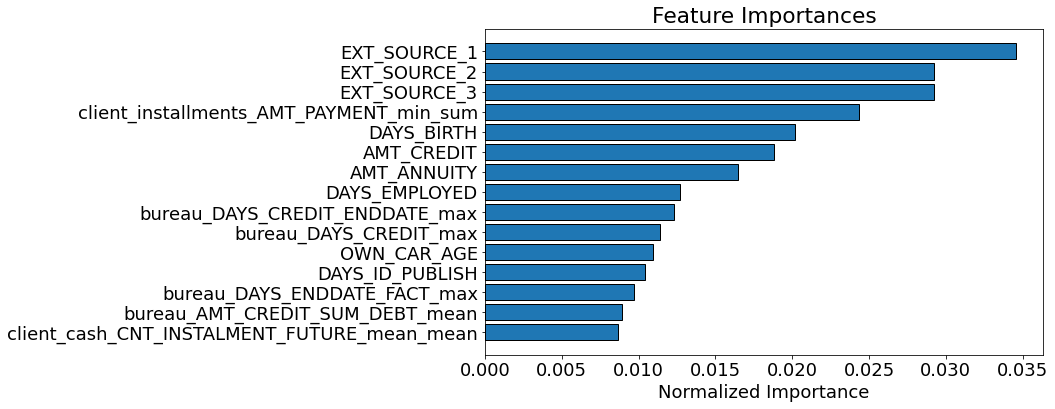

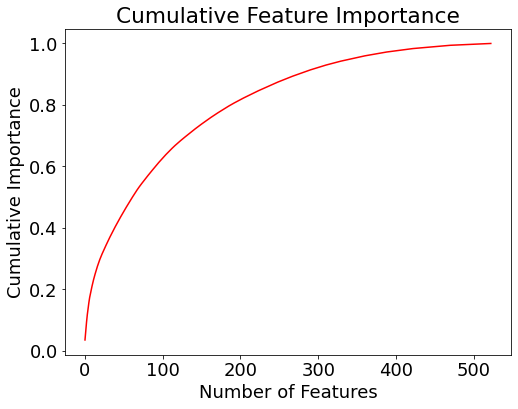

276 features required for 0.90 of cumulative importance


In [ ]:
norm_feature_importances = plot_feature_importances(Second_round_feature_importances)

In [ ]:
norm_feature_importances.head()

,index,feature,importance,importance_normalized,cumulative_importance
0,19,EXT_SOURCE_1,151.5,0.034589,0.034589
1,20,EXT_SOURCE_2,128.0,0.029224,0.063813
2,21,EXT_SOURCE_3,128.0,0.029224,0.093037
3,360,client_installments_AMT_PAYMENT_min_sum,106.5,0.024315,0.117352
4,6,DAYS_BIRTH,88.5,0.020205,0.137557


In [ ]:
# Threshold for cumulative importance
threshold = 0.95

# Extract the features to keep
features_to_keep = list(norm_feature_importances[norm_feature_importances['cumulative_importance'] < threshold]['feature'])

# Create new datasets with smaller features
train_small = train[features_to_keep]
test_small = test[features_to_keep]

In [ ]:
# final data
train_small['TARGET']=train_labels
train_small.to_csv('m_train_small.csv', index = False)
test_small.to_csv('m_test_small.csv', index = False)

#Brouillon

In [ ]:
gc.enable()
#del train_features, valid_features
gc.collect()

172

In [ ]:
importlib.reload(functions)
from functions import *

In [ ]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                         train:  1.1 GiB
                train_features: 831.2 MiB
                   train_small: 770.4 MiB
                valid_features: 277.1 MiB
                          test: 175.7 MiB
                    test_small: 121.7 MiB
                   corr_matrix: 16.4 MiB
                         upper: 16.4 MiB
                  train_labels:  4.7 MiB
                     train_ids:  4.7 MiB
